In [12]:
import numpy as np
import math
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

### 1. Data Set
We get the Malaria Dataset first and then we'll print out a few of the samples and analyse them

In [13]:
# Load the dataset and the info (info is needed to show examples because of the function definition)
data, data_info = tfds.load("malaria", as_supervised=True, split="train", with_info=True)

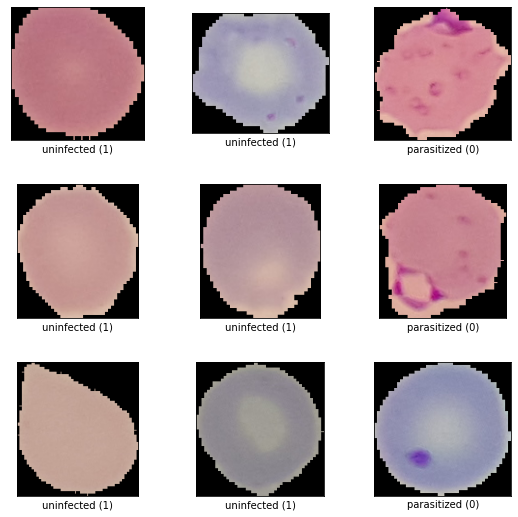

In [14]:
# Show a few examples of the dataset
fig = tfds.show_examples(data, data_info)

From looking at these images we can see that infected cells have darker spots. <br>
So we can give the network a nice performance boost by using greyscale as the color doesn't seem to be important here

In [15]:
# Turn the samples into greyscale
data = data.map(lambda sample, label: (tf.image.rgb_to_grayscale(sample), label))

Let's get all these images to the same size, as this is necessary for our CNN to work later. (Since the sides are already padded with zeroes we will use this method to get the correct aspect ratio as well)

Minimum height: 40
Minimum width: 46


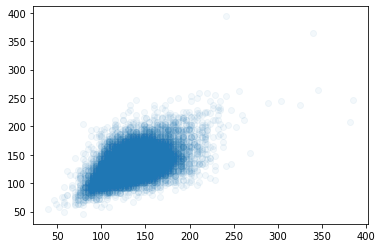

In [16]:
w = []
h = []
for sample in list(data):
  s = tf.shape(sample[0])
  h.append(s[0])
  w.append(s[1])

plt.scatter(np.array(h),np.array(w), marker="o", alpha=0.05)
print(f"Minimum height: {np.min(h)}")
print(f"Minimum width: {np.min(w)}")

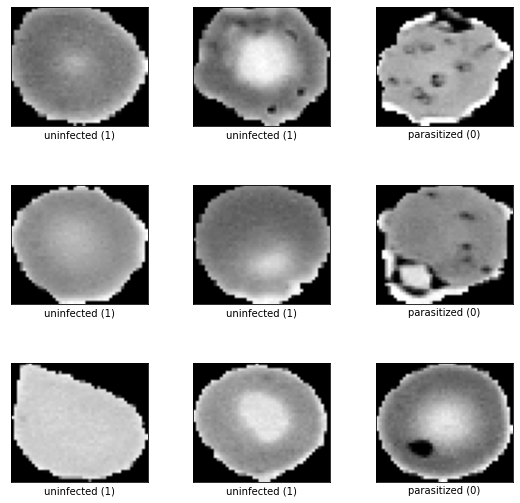

In [17]:
# Normalise the data
data = data.map(lambda sample, label: (tf.image.per_image_standardization(sample), label))

# Resize all images to the size of 40x46 (the minimum shape of all samples)
data = data.map(lambda sample, label: (tf.image.resize(sample, [np.min(h), np.min(w)]), label))

# Print some examples to see if the resizing, normalizing and grayscaling worked
fig = tfds.show_examples(data, data_info)

In [18]:
# Onehot encode the labels (we have to do this now because we can't print the examples otherwise)
data = data.map(lambda sample, label: (sample, tf.one_hot(label, 2)))

# Finish up the pipeline with prefetching, caching, batching and shuffeling
data = data.cache()
data = data.prefetch(tf.data.experimental.AUTOTUNE)

# Split the data into test and training data (80-20)
# We do the batching after the splitting because this makes it easier to split
batch_size = 256

train_size = int(data_info.splits["train"].num_examples * 0.8)
data_train = data.take(train_size)
data_train = data_train.batch(batch_size)
data_train = data_train.shuffle(buffer_size=batch_size)
data_test = data.skip(train_size)
data_test = data_test.batch(batch_size)

### 2. Model
Create a CNN

In [19]:
tf.keras.backend.clear_session()
epochs = 20
lr = 0.0005
# We used a architecture with two Convolution Layers followed by a Max Pooling Layer
# because it was suggested online and because it performed best for us.
# For the first layer we used a single convolution because adding two yielded weird 
# results.
# At the end we used a simple MLP to classify the sample using the features
# extracted from the CNN.
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", input_shape=(40,46,1)),
                                    tf.keras.layers.MaxPooling2D(2, strides=1),
                                    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, strides=1),
                                    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, strides=1),
                                    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(512, activation=tf.keras.activations.relu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
                                    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)])

### 3. Training
Train the Model

In [ ]:
# As a optimizer we used Adam because it is simply the best for most use cases
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Because we used a one-hot encoding for our labels we chose categorical crossentropy
model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])

# Get the initial loss and accuracies for both data sets
init_train_metrics = model.evaluate(data_train, verbose=0)
init_test_metrics = model.evaluate(data_test, verbose=0)

# Hide warnings
tf.get_logger().setLevel("ERROR")

# Train the CNN and the Classifier
history = model.fit(data_train, validation_data = data_test, epochs=epochs, shuffle=True)

Epoch 1/20
87/87 [==============================] - 21s 240ms/step - loss: 0.5679 - accuracy: 0.7392 - val_loss: 0.3144 - val_accuracy: 0.8735
Epoch 2/20
87/87 [==============================] - 21s 237ms/step - loss: 0.2439 - accuracy: 0.9082 - val_loss: 0.1874 - val_accuracy: 0.9298
Epoch 3/20
87/87 [==============================] - 20s 233ms/step - loss: 0.1823 - accuracy: 0.9337 - val_loss: 0.1660 - val_accuracy: 0.9381
Epoch 4/20
48/87 [===============>..............] - ETA: 8s - loss: 0.1678 - accuracy: 0.9399

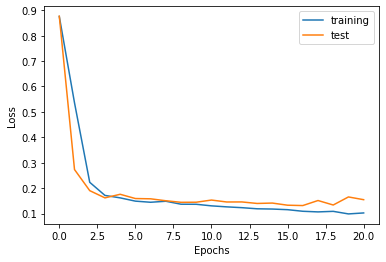

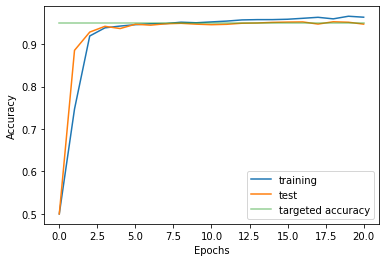

In [ ]:
# Combine the losses and averages while training with the ones before training
train_loss = np.concatenate(([init_train_metrics[0]], history.history["loss"]))
train_acc = np.concatenate(([init_train_metrics[1]], history.history["accuracy"]))

test_loss = np.concatenate(([init_test_metrics[0]], history.history["val_loss"]))
test_acc = np.concatenate(([init_test_metrics[1]], history.history["val_accuracy"]))

# draw the loss plot
plt.figure()
line1, = plt.plot(train_loss)
line2, = plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1, line2), ("training", "test"))
plt.show()

# draw the accuracy plot
plt.figure()
line1, = plt.plot(train_acc)
line2, = plt.plot(test_acc)
line3, = plt.plot([0.95] * (epochs + 1))
line3.set_alpha(0.5)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend((line1, line2, line3), ("training", "test", "targeted accuracy"))
plt.show()

